# **Lunar Lander**

In [1]:
from stable_baselines3 import DQN, A2C
import gymnasium as gym
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import glob

2025-04-02 11:36:48.149591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 11:36:48.160223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743604608.173407  100036 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743604608.177056  100036 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 11:36:48.189865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# **A2C**

In [4]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
tmp_path = f"./results/lunar_lander/A2C_run_{run_id}"
new_logger = configure(tmp_path, ["stdout", "csv"])

env = gym.make("LunarLander-v3")
#model = A2C(policy = "MlpPolicy", env = env, device="cpu")
model = A2C(
    policy="MlpPolicy",
    env=env,
    device="cpu",
    learning_rate=7e-4,          # slightly lower than DQN
    n_steps=5,                   # default works okay, can try 8 or 16
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.01,               # encourage exploration
    vf_coef=0.5,
    max_grad_norm=0.5,
    use_rms_prop=True,
    normalize_advantage=True
)

# Uncomment this line if you want to keep training an old model
#model = A2C.load("./model/A2C_LunarLander")
#model.set_env(env)

model.set_logger(new_logger)
model.learn(total_timesteps=300_000)

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

print('modelo treinado')

Logging to ./results/lunar_lander/A2C_run_20250402_113652


In [5]:
env = gym.make("LunarLander-v3", render_mode='human')
(obs,_) = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()
      break

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [6]:
model.save("./model/A2C_LunarLander")

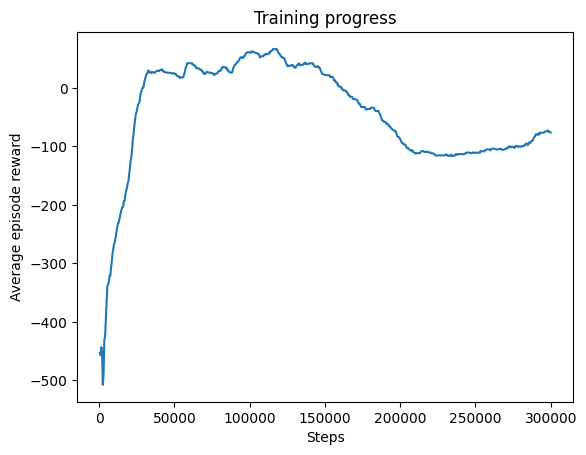

In [7]:
# Get all progress.csv files from sorted run folders
base_path = "results/lunar_lander/"
csv_paths = sorted(glob.glob(os.path.join(base_path, "A2C_run_*/progress.csv")))

all_dfs = []
total_timesteps_offset = 0

for path in csv_paths:
    df = pd.read_csv(path)

    # Adjust total_timesteps to be cumulative
    df['time/total_timesteps'] += total_timesteps_offset
    total_timesteps_offset = df['time/total_timesteps'].iloc[-1]

    all_dfs.append(df)

# Concatenate the adjusted data
combined_df = pd.concat(all_dfs, ignore_index=True)

# Plot as a single line
plt.figure(figsize=(10, 6))
plt.plot(combined_df['time/total_timesteps'], combined_df['rollout/ep_rew_mean'])
plt.xlabel('Steps')
plt.ylabel('Average episode reward')
plt.title('Cumulative Training Progress')
plt.grid(True)
plt.tight_layout()
plt.show()

# **DQN**

In [30]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
tmp_path = f"./results/lunar_lander/DQN_run_{run_id}"
new_logger = configure(tmp_path, ["stdout", "csv"])

env = gym.make("LunarLander-v3")
model = DQN(
    policy = "MlpPolicy",
    env = env,
    device="cpu",
    learning_rate=0.001,
    buffer_size=10_000,
    batch_size=64,
    gamma=0.99,
    target_update_interval=100,
    exploration_fraction=0.0067, # Explicar aqui que na vdd isso é outra coisa mas funcionou igual
    exploration_initial_eps=1.0,
    exploration_final_eps=0.01   
)

# Uncomment this line if you want to keep training an old model
#model = DQN.load("./model/DQN_LunarLander")
#model.set_env(env)

model.set_logger(new_logger)
model.learn(total_timesteps=1_000_000)

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

print('modelo treinado')

Logging to ./results/lunar_lander/DQN_run_20250402_111419
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 83.5     |
|    ep_rew_mean      | -173     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2077     |
|    time_elapsed     | 0        |
|    total_timesteps  | 334      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.32     |
|    n_updates        | 58       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -187     |
|    exploration_rate | 0.879    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2219     |
|    time_elapsed     | 0        |
|    total_timesteps  | 816      |
| train/              |          |
|    learning_rate    | 0.001   

In [24]:
env = gym.make("LunarLander-v3", render_mode='human')
(obs,_) = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()
      break

In [33]:
model.save("./model/DQN_LunarLander")

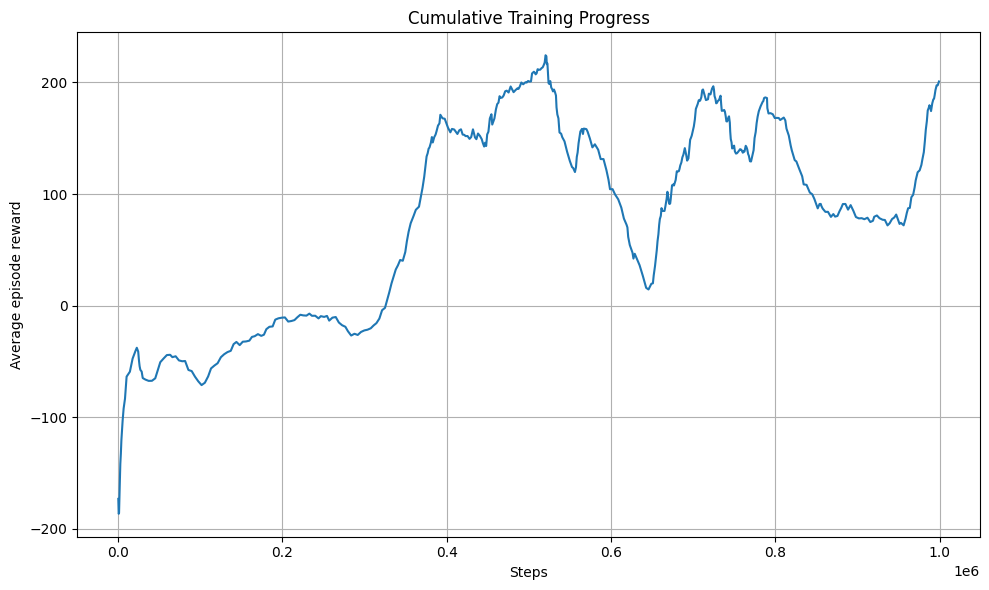

In [32]:
# Get all progress.csv files from sorted run folders
base_path = "results/lunar_lander/"
csv_paths = sorted(glob.glob(os.path.join(base_path, "DQN_run_*/progress.csv")))

all_dfs = []
total_timesteps_offset = 0

for path in csv_paths:
    df = pd.read_csv(path)

    # Adjust total_timesteps to be cumulative
    df['time/total_timesteps'] += total_timesteps_offset
    total_timesteps_offset = df['time/total_timesteps'].iloc[-1]

    all_dfs.append(df)

# Concatenate the adjusted data
combined_df = pd.concat(all_dfs, ignore_index=True)

# Plot as a single line
plt.figure(figsize=(10, 6))
plt.plot(combined_df['time/total_timesteps'], combined_df['rollout/ep_rew_mean'])
plt.xlabel('Steps')
plt.ylabel('Average episode reward')
plt.title('Cumulative Training Progress')
plt.grid(True)
plt.tight_layout()
plt.show()